In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import math
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn import preprocessing
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import random 
random.seed(33)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

In [23]:
listings = pd.read_csv('../Data/listings_cleanTotal.csv')

In [24]:
performance2017 = pd.read_excel('../Data/Performance Approach V0.xls')
columns_to_keep = ['id', 'Published_Before_2017', '2017_Total_Income_Est','2017_Total_Number_Reviews']
performance2017 = performance2017[columns_to_keep]

In [25]:
listingsPerformance = pd.concat([listings, performance2017], axis=1, join='inner')

In [26]:
#We remove listings that didn't have performance or have no availability in 2018 as it might mean that they are not really available for booking
listingsPerfClean = listingsPerformance[(listingsPerformance['Published_Before_2017']=='yes') & (listingsPerformance['2017_Total_Number_Reviews']!=0) & (listingsPerformance['availability_365']!=0)]

In [27]:
listingsPerfClean.shape

(9058, 48)

In [28]:
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms','bedrooms', 'minimum_nights',
                      'review_scores_value','price','2017_Total_Number_Reviews']
boolean_features = ['instant_bookable', 'is_business_travel_ready', 'Parking', 'Wifi']
categorical_features = ['property_type', 'cancellation_policy', 'neighbourhood_cleansed']
#listings_categorical = pd.get_dummies(listingsPerfClean[categorical_features], columns=categorical_features, 
#                                        prefix=["Property", "CancPol"])
#listingsPerfClean2 = pd.concat([listingsPerfClean['room_type'],listingsPerfClean[numerical_features],
#                             listings_categorical,listingsPerfClean[boolean_features]], axis=1)
listingsPerfClean2 = pd.concat([listingsPerfClean['room_type'],listingsPerfClean[numerical_features],
                              listingsPerfClean[categorical_features],listingsPerfClean[boolean_features]], axis=1)

In [29]:
listingsHome = listingsPerfClean2[listingsPerfClean2['room_type']=='Entire home/apt'].drop(['room_type'],axis=1)
listingsRoom = listingsPerfClean2[listingsPerfClean2['room_type']=='Private room'].drop(['room_type'],axis=1)
listingsSharedRoom = listingsPerfClean2[listingsPerfClean2['room_type']=='Shared room'].drop(['room_type'],axis=1)

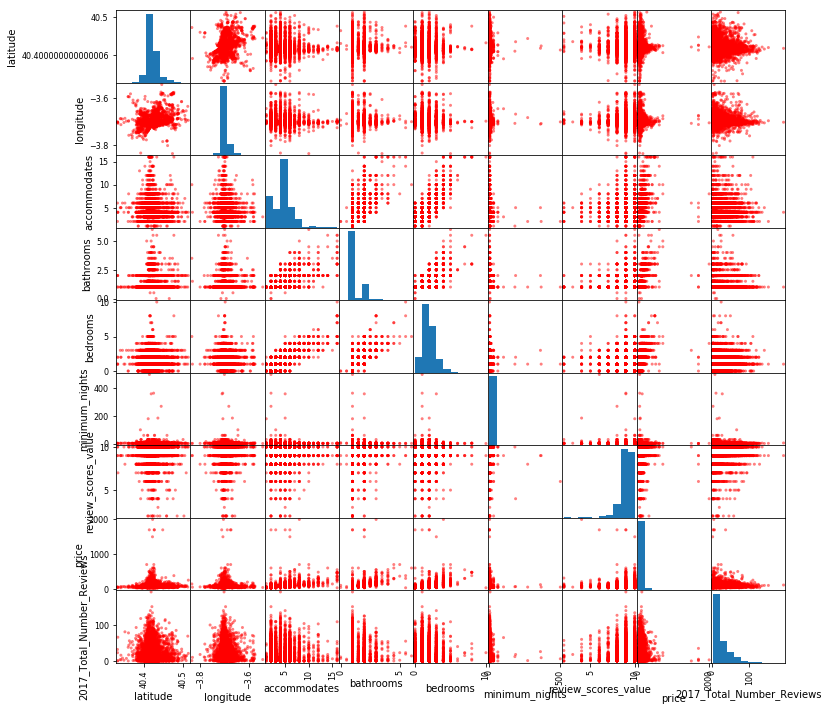

In [85]:
axs = pd.scatter_matrix(listingsHome[numerical_features],
                        figsize=(12, 12), c='red')

Accommodates, bathrooms and bedrooms seem to be the only features with a "clear" positive correlation

We study deeper minimum nights and price, as they seem to have some outliers that are distorting the sample

In [86]:
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,Property_Apartment,...,Property_Vacation home,Property_Villa,CancPol_flexible,CancPol_moderate,CancPol_strict,CancPol_super_strict_30,instant_bookable,is_business_travel_ready,Parking,Wifi
count,6079.000000,6079.000000,6079.00000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,...,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,40.419911,-3.698686,4.21237,1.260322,1.495147,2.978121,9.221911,88.598783,21.098865,0.886659,...,0.006087,0.000494,0.178977,0.371278,0.431650,0.018095,0.576740,0.065800,0.000658,0.966935
std,0.016191,0.018319,1.95637,0.522100,0.967012,10.863766,0.937294,74.604806,22.334638,0.317035,...,0.077785,0.022211,0.383364,0.483186,0.495347,0.133306,0.494117,0.247953,0.025645,0.178820
min,40.332908,-3.835498,1.00000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410834,-3.707186,3.00000,1.000000,1.000000,2.000000,9.000000,56.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417518,-3.701954,4.00000,1.000000,1.000000,2.000000,9.000000,74.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425289,-3.696230,5.00000,1.000000,2.000000,3.000000,10.000000,100.000000,31.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,40.512476,-3.543342,16.00000,6.000000,10.000000,500.000000,10.000000,2000.000000,193.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
#We remove outliers manually trying to see if there is correlation between variables
p98 = np.percentile(listingsHome['minimum_nights'], 98)
listingsHome = listingsHome[listingsHome['minimum_nights']<=p98]
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,instant_bookable,is_business_travel_ready,Parking,Wifi
count,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000
mean,40.419852,-3.698676,4.225243,1.261329,1.496475,2.295737,9.227425,88.679758,21.111950,0.584256,0.066465,0.000671,0.966767
std,0.016111,0.018267,1.964419,0.523513,0.969696,1.166291,0.922081,74.763751,22.366483,0.492891,0.249115,0.025904,0.179259
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410846,-3.707151,3.000000,1.000000,1.000000,2.000000,9.000000,56.000000,4.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417414,-3.701951,4.000000,1.000000,1.000000,2.000000,9.000000,74.000000,13.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425210,-3.696273,5.000000,1.000000,2.000000,3.000000,10.000000,100.000000,31.000000,1.000000,0.000000,0.000000,1.000000
max,40.512476,-3.543342,16.000000,6.000000,10.000000,8.000000,10.000000,2000.000000,193.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
p98 = np.percentile(listingsHome['price'], 98)
listingsHome = listingsHome[listingsHome['price']<=p98]
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,instant_bookable,is_business_travel_ready,Parking,Wifi
count,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,40.419821,-3.698631,4.137500,1.232791,1.454281,2.297945,9.225171,81.986644,21.153596,0.585959,0.066096,0.000514,0.966267
std,0.016174,0.018392,1.788844,0.465043,0.904385,1.168430,0.919699,37.149663,22.382219,0.492598,0.248471,0.022661,0.180556
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410763,-3.707141,3.000000,1.000000,1.000000,2.000000,9.000000,55.000000,4.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417307,-3.701953,4.000000,1.000000,1.000000,2.000000,9.000000,72.000000,13.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425230,-3.696259,5.000000,1.000000,2.000000,3.000000,10.000000,99.000000,31.000000,1.000000,0.000000,0.000000,1.000000
max,40.511100,-3.543342,16.000000,5.500000,10.000000,8.000000,10.000000,240.000000,193.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
listingsHome = listingsHome[listingsHome['accommodates']<=10]
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,instant_bookable,is_business_travel_ready,Parking,Wifi
count,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000
mean,40.419841,-3.698613,4.077613,1.225164,1.434633,2.300448,9.226112,81.521904,21.142118,0.585547,0.066057,0.000517,0.966023
std,0.016191,0.018353,1.646899,0.453514,0.870493,1.169934,0.921310,36.655840,22.363738,0.492670,0.248404,0.022743,0.181186
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410755,-3.707125,3.000000,1.000000,1.000000,2.000000,9.000000,55.000000,4.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417356,-3.701937,4.000000,1.000000,1.000000,2.000000,9.000000,71.000000,13.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425277,-3.696227,5.000000,1.000000,2.000000,3.000000,10.000000,98.000000,31.000000,1.000000,0.000000,0.000000,1.000000
max,40.511100,-3.543342,10.000000,4.000000,5.000000,8.000000,10.000000,240.000000,193.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
#We modify latitude and longitude measuring the axis distance to "Puerta del Sol"
listingsHome['latitude'] = abs(listingsHome['latitude']- 40.41694)
listingsHome['longitude'] = abs(listingsHome['longitude'] -(-3.70361))

/home/dsc/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


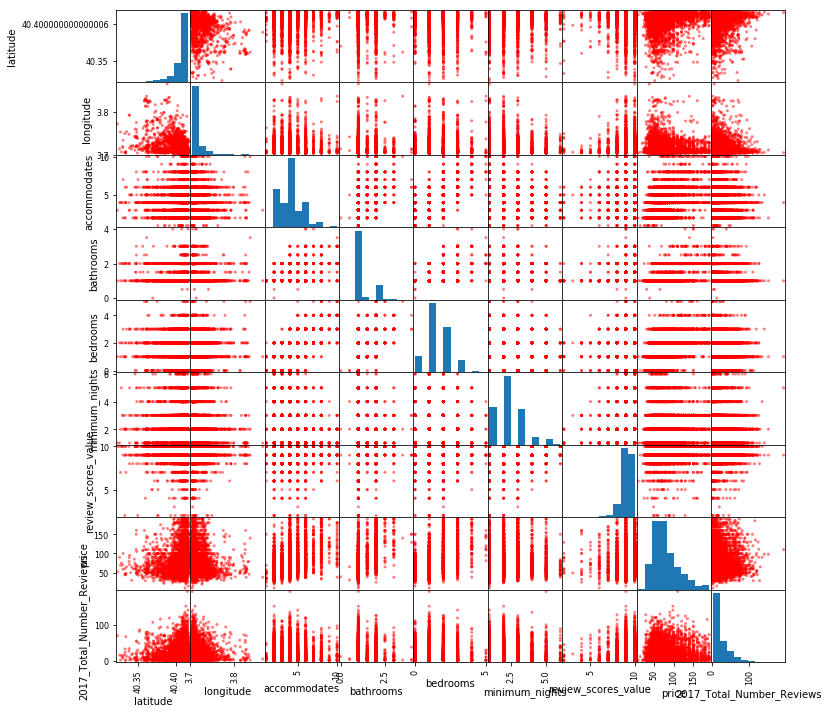

In [24]:
axs = pd.scatter_matrix(listingsHome[numerical_features],
                        figsize=(12, 12), c='red')

In [55]:
#We keep only the variables that seemed to be more correlated with the total number of reviews in the previous trials
X_or = listingsHome.loc[:,['price', 'review_scores_value', 'accommodates','latitude', 'longitude']].values
y = listingsHome['2017_Total_Number_Reviews']
y = y.reshape(-1,1)

In [57]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X_or)

In [58]:
X = X[:,1:]
X.shape

(5602, 20)

In [59]:
type(X_or)

numpy.ndarray

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.25,
                            random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4201, 20)
(1401, 20)
(4201, 1)
(1401, 1)


In [61]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

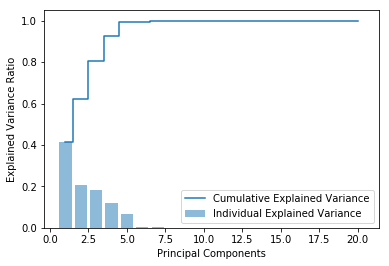

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [62]:
cov_X = np.cov(X_train.T) # Construct the covariance matrix.
eigen_vals, eigen_vecs = np.linalg.eig(cov_X) #Decompose the covariance matrix into its eigenvectors and eigenvalues.

import matplotlib.pyplot as plt
sorted_eigen_vals = sorted(eigen_vals, reverse = True)
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted_eigen_vals]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,len(var_exp)+1), var_exp, alpha = 0.5, align = 'center',
        label = 'Individual Explained Variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
        label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()
pca = []
for i in range(0,5) :
    #print(str(i+1) + ' principal component is:' + str(X.columns.values[np.where(eigen_vals==sorted_eigen_vals[i])]))
    pca.extend(X.columns.values[np.where(eigen_vals==sorted_eigen_vals[i])])
print(pca)
X = X[pca]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.25,
                            random_state=0)
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

In [64]:
print(np.max(y_train), np.min(y_train), np.mean(y_train))
print(np.max(y_test), np.min(y_test), np.mean(y_test))

7.745230279611328 -0.8955617348345183 7.103735991888647e-17
5.134991025247478 -0.8955617348345183 0.02051795031584543


In [65]:
def train_and_validate(method_name, slr, X_train,y_train, X_test, y_test):
    slr.fit(X_train,y_train)
    y_train_pred = slr.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    y_test_pred = slr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print('Method: %s' %method_name)
    print('MSE on training: %.3f' %mse_train)
    print('r^2 on training: %.3f' %r2_train)
    print('MSE on test: %.3f' %mse_test)
    print('r^2 on test: %.3f' %r2_test)
    
    return y_test_pred

In [66]:
from sklearn.linear_model import SGDRegressor
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Compute MSE on training data
sgdreg = SGDRegressor(loss='squared_loss', penalty=None,  random_state=10)

method_name = 'Stochastic Gradient Descent Regression'
y_test_pred = train_and_validate(method_name, sgdreg, X_train,y_train, X_test, y_test)

Method: Stochastic Gradient Descent Regression
MSE on training: 1.006
r^2 on training: -0.006
MSE on test: 1.041
r^2 on test: -0.008


In [67]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0.05, l1_ratio=0.1)
y_test_pred = train_and_validate("Elastic Net", enet, X_train,y_train, X_test, y_test)

Method: Elastic Net
MSE on training: 0.999
r^2 on training: 0.001
MSE on test: 1.034
r^2 on test: -0.001


In [68]:
from sklearn import svm
slr_svr = svm.SVR(kernel='linear')
y_test_pred = train_and_validate("Support Vector Machine", slr_svr, X_train,y_train, X_test, y_test)

Method: Support Vector Machine
MSE on training: 1.130
r^2 on training: -0.130
MSE on test: 1.179
r^2 on test: -0.141


In [69]:
from sklearn.svm import SVR
slr_svr_rbf_1 = SVR(kernel='rbf', C=1)
y_test_pred_1 = train_and_validate("Support Vector Machine RBF", slr_svr_rbf_1, X_train,y_train, X_test, y_test)
slr_svr_rbf_2 = SVR(kernel='rbf', C=10)
y_test_pred_2 = train_and_validate("Support Vector Machine RBF", slr_svr_rbf_2, X_train,y_train, X_test, y_test)

Method: Support Vector Machine RBF
MSE on training: 1.082
r^2 on training: -0.082
MSE on test: 1.199
r^2 on test: -0.160
Method: Support Vector Machine RBF
MSE on training: 1.039
r^2 on training: -0.039
MSE on test: 1.233
r^2 on test: -0.193


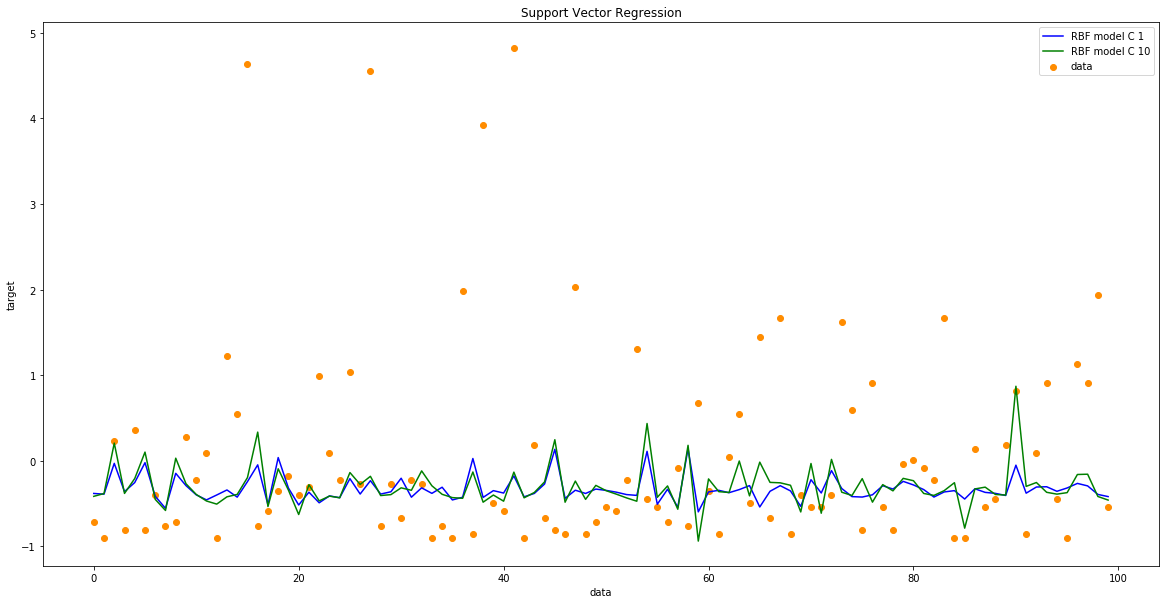

In [70]:
lw = 2
plt.scatter(range(0, 100), y_test[0:100], color='darkorange', label='data')
plt.hold('on')
plt.plot(range(0, 100), y_test_pred_1[0:100], color='b',label='RBF model C 1')
plt.plot(range(0, 100), y_test_pred_2[0:100], color='g',label='RBF model C 10')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [71]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(50,10,), max_iter=1000, learning_rate = 'adaptive')
y_test_pred = train_and_validate("Multi-layer Perceptron regressor", mlp, X_train,y_train, X_test, y_test)

Method: Multi-layer Perceptron regressor
MSE on training: 0.997
r^2 on training: 0.003
MSE on test: 1.035
r^2 on test: -0.002


In [72]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 180, 
          'max_depth': 1, 
          'min_samples_split': 2,
          'learning_rate': 0.2, 
          'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)

gbr.fit(X_train, y_train)
y_pred_gbr = train_and_validate("forward stage-wise", gbr, X_train,y_train, X_test, y_test)

Method: forward stage-wise
MSE on training: 0.965
r^2 on training: 0.035
MSE on test: 1.043
r^2 on test: -0.010


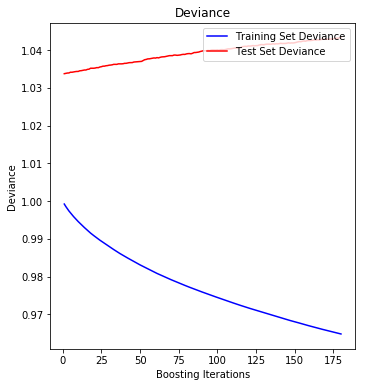

In [73]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

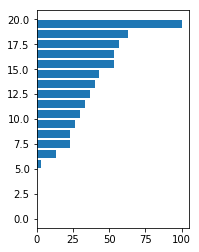

In [74]:
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
fig = plt.gcf()
fig.set_size_inches(20, 18)
plt.show()

In [ ]:
print(__doc__)

# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),
                          n_estimators=2000, random_state=0)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(range(0,100), y_test[0:100], c="k", label="training samples")
plt.plot(range(0,100), y_1[0:100], c="g", label="n_estimators=1", linewidth=1)
plt.plot(range(0,100), y_2[0:100], c="r", label="n_estimators=2000", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [35]:
listingsHome.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,property_type,cancellation_policy,neighbourhood_cleansed,instant_bookable,is_business_travel_ready,Parking,Wifi
1,0.003522,0.003228,2,1.0,0.0,2,9.0,65.0,36,Apartment,strict,Embajadores,1,0,0,1
2,0.007980,0.009836,2,1.0,0.0,2,8.0,40.0,21,Apartment,flexible,Argüelles,0,0,0,1
4,0.006477,0.008846,10,3.0,4.0,2,8.0,90.0,13,Apartment,moderate,Argüelles,0,0,0,1
5,0.005082,0.000344,3,1.0,0.0,3,10.0,55.0,1,Apartment,strict,Universidad,0,0,0,1
6,0.003011,0.005973,4,1.0,2.0,5,10.0,115.0,11,Apartment,moderate,Justicia,0,0,0,1


In [37]:
listingsHome.to_csv('../Data/listingsHome.csv', index=False)